# San Francisco Crime Prediction
__Authors: Marguerit Nicolas, Palma François, Réaubourg Alexandre__

In this notebook we try to predict crime that will happen one day based on crime that happened the previous day.

We got the data from https://www.kaggle.com/kaggle/san-francisco-crime-classification?select=train.csv

The test.csv from this dataset does not help us due to lacking some of the data we need for classifcation, thus we ignore it and make our test data from the train.csv file.

Considering the large size of this dataset, we felt that we didn't need a bigger sample size.


In [1]:
# We mount our drive for google colab purposes
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# We get the csv file from there, feel free to change it for your purposes
try:
    with open("drive/MyDrive/Colab Notebooks/train.csv") as inputfile:
        aliste = inputfile.readlines()[1:]
except:
    with open("train.csv") as inputfile:
        aliste = inputfile.readlines()[1:]

## Filtering
This is where we filter and trim down the data to the columns we want.
We realized after the fact that we could have used panda or something similar but it was already done and we don't really understand panda all that well to begin with.

In [4]:
bliste = []
cliste = []
for i in range(len(aliste)):
    # We remove these types as we don't think they can help us predict crime
    if aliste[i][1] not in ["NON-CRIMINAL", "OTHER OFFENSES", "WARRANTS", "SUSIPCIOUS OCC"]:
        temp = aliste[i].split(",")
        if temp[-1] != "90.0\n":
            bliste += [[temp[0][:-9]]  + [float(temp[-2])] + [float(temp[-1][:-1])]]
            cliste += [[float(temp[-2])] + [float(temp[-1][:-1])]]

bliste = bliste[::-1]
bliste[:20]

[['2003-01-06', -122.394925721424, 37.738211541051996],
 ['2003-01-06', -122.39053140418699, 37.78060707982429],
 ['2003-01-06', -122.403390364804, 37.780265577696],
 ['2003-01-06', -122.447363507104, 37.7319475636101],
 ['2003-01-06', -122.459033097784, 37.7140562686562],
 ['2003-01-06', -122.389768984951, 37.7305636925712],
 ['2003-01-06', -122.389768984951, 37.7305636925712],
 ['2003-01-06', -122.472984835661, 37.7825523645525],
 ['2003-01-06', -122.41407332511, 37.7516845989529],
 ['2003-01-06', -122.42069168079901, 37.790577071030796],
 ['2003-01-06', -122.411518820366, 37.78694089985761],
 ['2003-01-06', -122.431046366089, 37.7830295716044],
 ['2003-01-06', -122.431046366089, 37.7830295716044],
 ['2003-01-06', -122.431046366089, 37.7830295716044],
 ['2003-01-06', -122.39166839300199, 37.7577932955113],
 ['2003-01-06', -122.39166839300199, 37.7577932955113],
 ['2003-01-06', -122.423031175095, 37.785481874719],
 ['2003-01-06', -122.39041695551701, 37.7355926106176],
 ['2003-01-06',

## Projection
We find the bounds of the coordinates which will help us make the bins.

We ultimately want to project our coordinates unto a square matrix, thus we first find the min and max of both coordinates.

In [5]:
Xmaxi = bliste[0][-2]
Xmini = bliste[0][-2]
Ymaxi = bliste[0][-1]
Ymini = bliste[0][-1]

for liste in bliste:
    if liste[-2] > Xmaxi:
        Xmaxi = liste[-2]
    if liste[-2] < Xmini:
        Xmini = liste[-2]
    if liste[-1] > Ymaxi:
        Ymaxi = liste[-1]
    if liste[-1] < Ymini:
        Ymini = liste[-1]

print(Ymaxi, Ymini)
print(Xmaxi, Xmini)

37.819975492297004 37.7078790224135
-122.36493749408001 -122.51364206429


### Insertion

We need to place each coordinate into the appropriate bin.

We first define the binsize and what each bin corresponds to, coordinates wise.

Then, we sort each row of data in the bins and find what bin is appropriate through a dichotomic search algorithm.

Finally, we get a list that gives us the coordinates in the matrix of each datapoint.

In [6]:
Xbins = [Xmini]
Ybins = [Ymini]
binsize = 100
for i in range(1, binsize + 1):
    Xbins += [Xmini * (binsize - i) / binsize + Xmaxi * i / binsize]
    Ybins += [Ymini * (binsize - i) / binsize + Ymaxi * i / binsize]

def binnumber(value, bins):
    testvalue = len(bins) // 2
    bornemin = 0
    bornemax = len(bins) - 1;
    while not (value <= bins[testvalue] and value >= bins[testvalue - 1]):
        if value > bins[testvalue]:
            bornemin = testvalue
        else:
            bornemax = testvalue
        testvalue = bornemin // 2 + bornemax // 2 + int(bornemin == testvalue)
    return testvalue - 1

fliste = []
for ligne in bliste:
    temp = ligne.copy()
    temp[-1] = binnumber(temp[-1], Ybins)
    temp[-2] = binnumber(temp[-2], Xbins)
    fliste += [temp]

fliste[:10]

[['2003-01-06', 79, 27],
 ['2003-01-06', 82, 64],
 ['2003-01-06', 74, 64],
 ['2003-01-06', 44, 21],
 ['2003-01-06', 36, 5],
 ['2003-01-06', 83, 20],
 ['2003-01-06', 83, 20],
 ['2003-01-06', 27, 66],
 ['2003-01-06', 66, 39],
 ['2003-01-06', 62, 73]]

#### Crime heatmap

For illustration purposes, here is a scatterplot of each crime in our dataset.

Interestingly, we can see the map of San Francisco emerge from it.

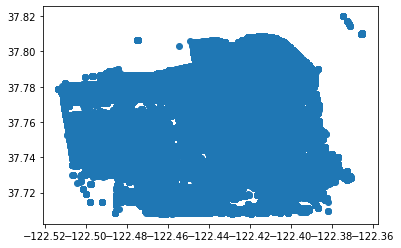

In [7]:
dliste = np.array(cliste)
plt.scatter(dliste[:][:,0], dliste[:][:,1])

#### Histogram 1
To illustrate where the crimes happen the most, here is a histogram of all the crimes in relation to their Y coordinates. They seem to be concentrated mostly in the north of the city.

(array([ 42892.,  61829.,  63246.,  53928.,  92319., 118465., 283175.,
        110569.,  49834.,   1725.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

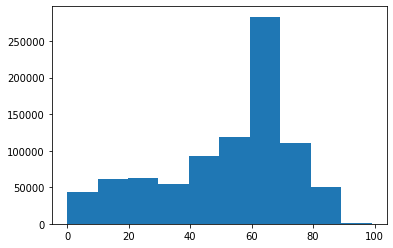

In [8]:
plt.hist(np.array(fliste)[:, -1].astype(int))

#### Histogram 2

This one is for the X coordinate. The crimes seem to be concentrated mostly in the east.

(array([ 12897.,  18658.,  32988.,  41148.,  65558., 117409., 309010.,
        213535.,  59996.,   6783.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

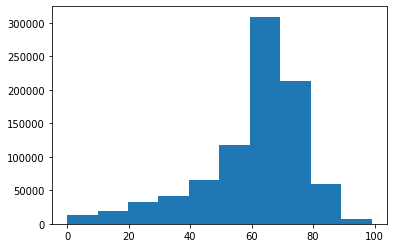

In [9]:
plt.hist(np.array(fliste)[:, -2].astype(int))

#### Dates
We sort each different date in a list and sort them, we'll need to construct the matrix of each day's crimemap and we need to know where to sort each datapoint.

In [10]:
dates = set()

for ligne in fliste:
    dates.add(ligne[0])

datelist = sorted(dates)

datedico = {}
for i in range(len(datelist)):
    datedico[datelist[i]] = i

print(len(dates))

2249


### Matrix construction

We can now construct the matrix for each day. Each matrix will be a binary square matrix of binsize * binsize dimensions where a 0 indicates no crime that day in that bin and 1 indicates at least one crime.

In [11]:
matrices = np.zeros((2249, binsize, binsize))
for ligne in fliste:
    matrices[datedico[ligne[0]], ligne[1], ligne[2]] = 1
matrices[:, 0].shape

(2249, 100)

### Data split
Now we can split the data into train and test.
The output is the crimes of the next day.

We choose to take 80 percent of the data for training purposes.

In [12]:
X = matrices[:-1]
Y = matrices[1:]

testrange = len(X) * 80 // 100

x_train = X[:testrange]
x_test = X[testrange:]
y_train = Y[:testrange]
y_test = Y[testrange:]

## Model construction
We construct a multi layer perceptron based model with 2 hidden layers.

We compile using binary crossentropy due to the data being binary.

Epoch 1/10
57/57 [==============================] - 3s 44ms/step - loss: 0.1975 - accuracy: 0.0535
Epoch 2/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0868 - accuracy: 0.0743
Epoch 3/10
57/57 [==============================] - 2s 44ms/step - loss: 0.0821 - accuracy: 0.0870
Epoch 4/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0750 - accuracy: 0.1143
Epoch 5/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0626 - accuracy: 0.1800
Epoch 6/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0442 - accuracy: 0.2781
Epoch 7/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0266 - accuracy: 0.3372
Epoch 8/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0150 - accuracy: 0.3548
Epoch 9/10
57/57 [==============================] - 3s 44ms/step - loss: 0.0085 - accuracy: 0.3574
Epoch 10/10
57/57 [==============================] - 2s 44ms/step - loss: 0.0050 - accuracy: 0.3590


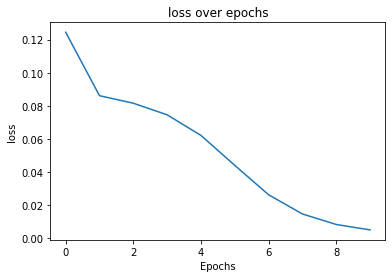

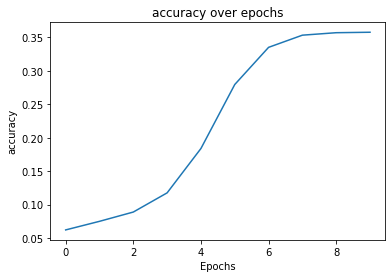

In [13]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(binsize * binsize, activation=tf.nn.relu),
    tf.keras.layers.Dense(binsize * binsize, activation=tf.nn.sigmoid),
    tf.keras.layers.Reshape(target_shape=y_train[0].shape)
])

model1.compile(optimizer='adam', 
               loss='binary_crossentropy',
               metrics=['accuracy'])

history = model1.fit(x_train, y_train, epochs=10)
for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

## Predictions

Now that our model is built, we test it on the test values.

15/15 [==============================] - 0s 6ms/step - loss: 0.1417 - accuracy: 0.0597


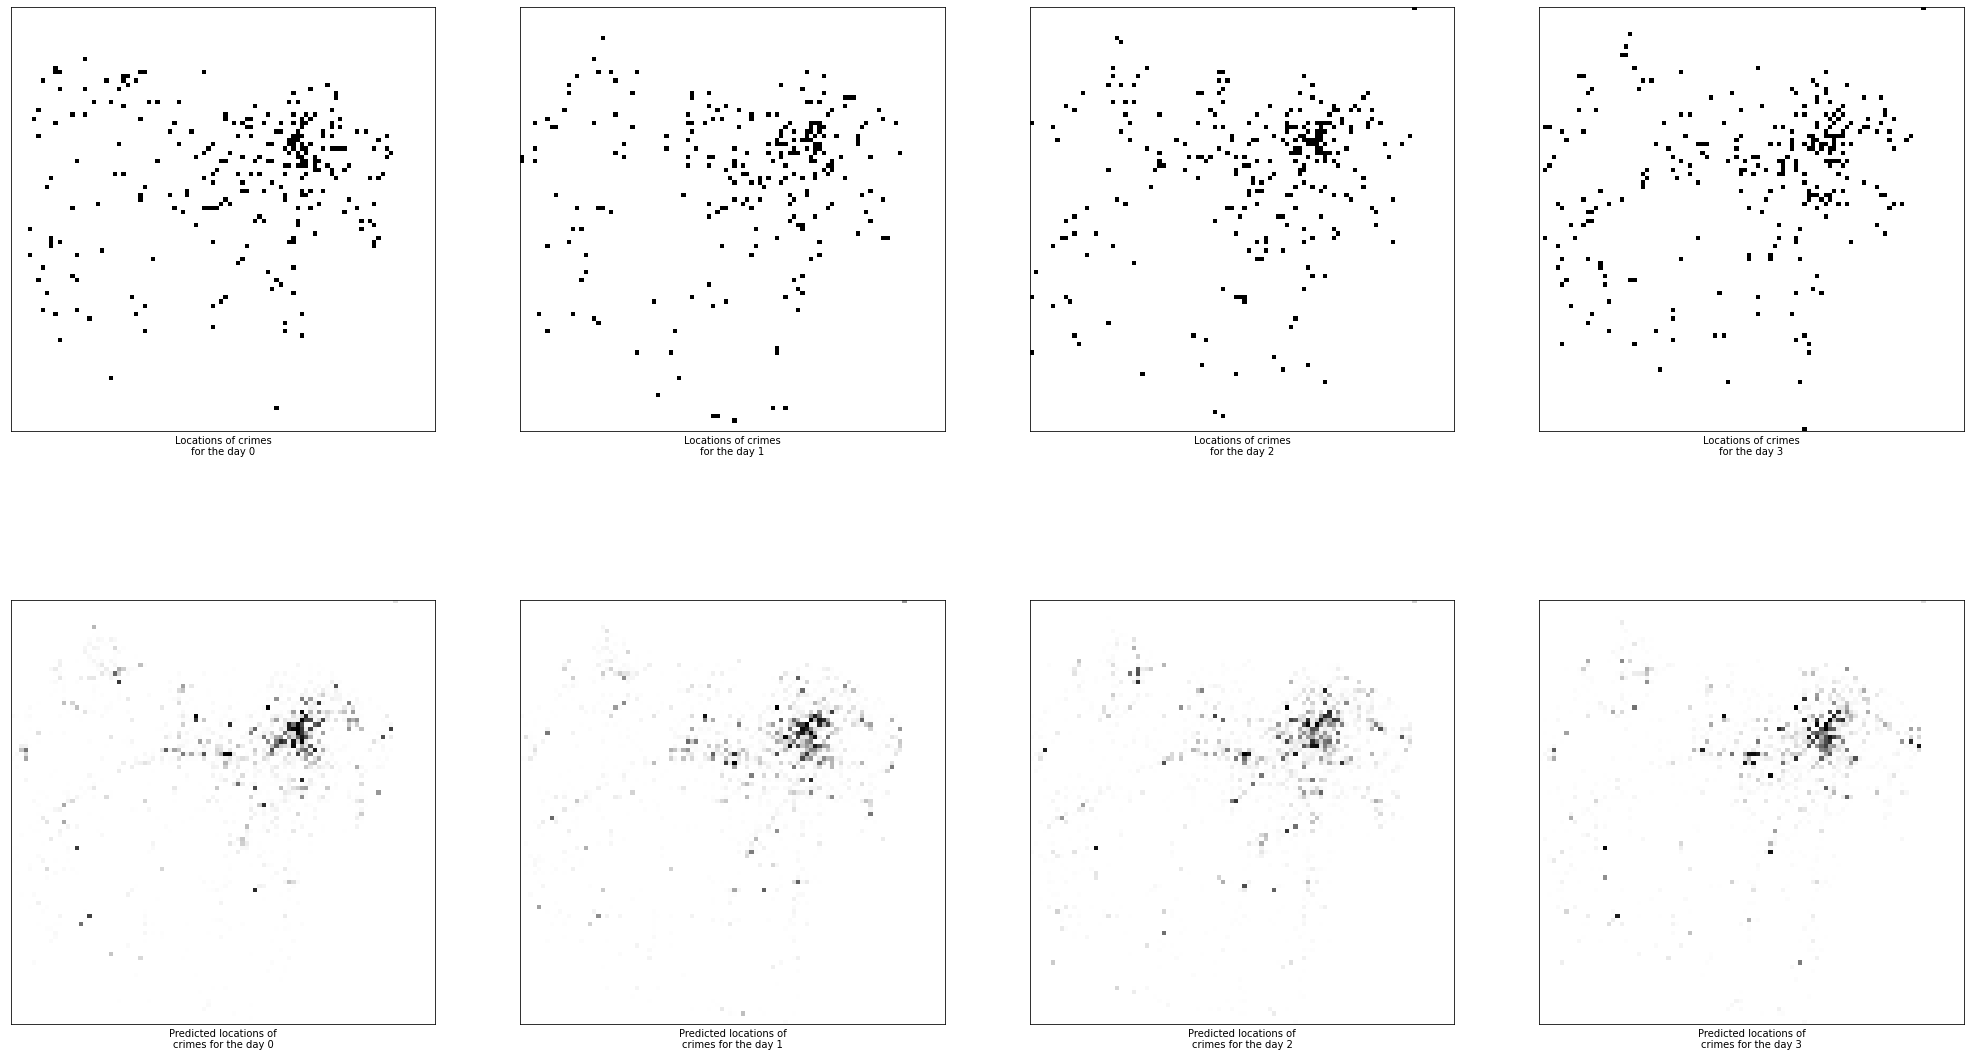

In [14]:
results = model1.evaluate(x_test, y_test)
resultsimg = model1.predict(x_test)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(35,20))
for i in range(axes.shape[1]):
  axes[0][i].imshow(y_test[i], cmap=plt.cm.binary, origin='lower')
  axes[0][i].set_xticks([])
  axes[0][i].set_yticks([])
  axes[0][i].set_xlabel("Locations of crimes\nfor the day " + str(i))
  axes[1][i].imshow(resultsimg[i], cmap=plt.cm.binary, origin='lower')
  axes[1][i].set_xticks([])
  axes[1][i].set_yticks([])
  axes[1][i].set_xlabel("Predicted locations of\ncrimes for the day " + str(i))

## Model 2
We now try a different model to see how the results differ.

In [15]:
inp = tf.keras.layers.Input(x_train[0].shape)
a = tf.keras.layers.Reshape(target_shape=(binsize, binsize, 1)) (inp)
a = tf.keras.layers.Conv2D(filters=32, activation=tf.nn.relu, kernel_size=3)(a)
a = tf.keras.layers.MaxPooling2D() (a)
a = tf.keras.layers.Conv2D(filters=64, activation=tf.nn.relu, kernel_size=3) (a)
a = tf.keras.layers.MaxPooling2D() (a)
a = tf.keras.layers.Conv2D(binsize, activation=tf.nn.relu, kernel_size=3) (a)
a = tf.keras.layers.MaxPooling2D() (a)
a = tf.keras.layers.Flatten() (a)
a = tf.keras.layers.Dense(20, activation=tf.nn.sigmoid) (a)
a = tf.keras.layers.Dense(binsize * binsize, activation=tf.nn.softmax) (a)
out = tf.keras.layers.Reshape(target_shape=(binsize, binsize)) (a)

model2 = tf.keras.Model(inp, out)
model2.build(input_shape=x_train[0].shape)
model2.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=[tf.keras.metrics.CategoricalCrossentropy()])
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 100)       57700 

In [16]:
model2.fit(x_train, y_train, epochs=5)

Epoch 1/5
57/57 [==============================] - 3s 12ms/step - loss: 11.2985 - categorical_crossentropy: 11.2985
Epoch 2/5
57/57 [==============================] - 1s 11ms/step - loss: 10.0399 - categorical_crossentropy: 10.0399
Epoch 3/5
57/57 [==============================] - 1s 11ms/step - loss: 9.8475 - categorical_crossentropy: 9.8475
Epoch 4/5
57/57 [==============================] - 1s 12ms/step - loss: 9.8074 - categorical_crossentropy: 9.8074
Epoch 5/5
57/57 [==============================] - 1s 11ms/step - loss: 9.7664 - categorical_crossentropy: 9.7664


15/15 [==============================] - 0s 7ms/step - loss: 10.1723 - categorical_crossentropy: 10.1723


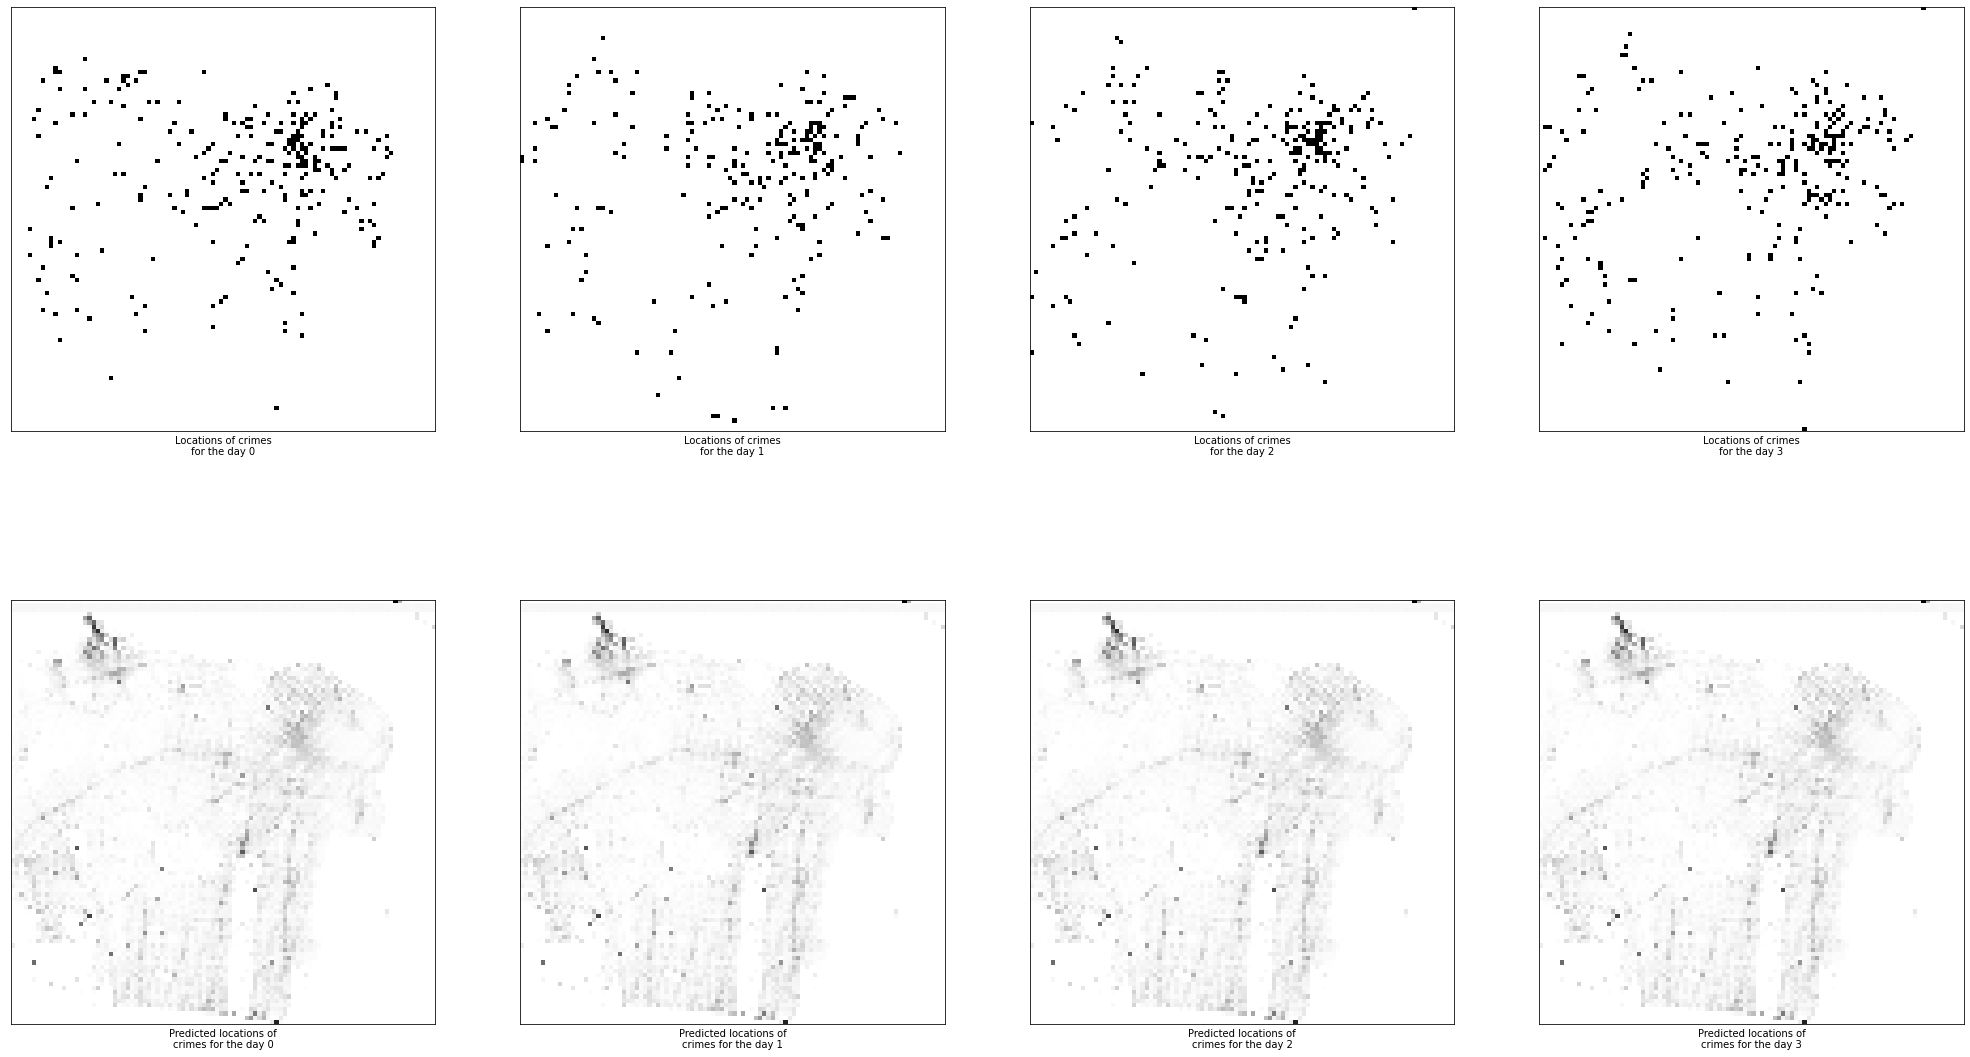

In [17]:
results = model2.evaluate(x_test, y_test)
resultsimg = model2.predict(x_test)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(35,20))
for i in range(axes.shape[1]):
  axes[0][i].imshow(y_test[i], cmap=plt.cm.binary, origin='lower')
  axes[0][i].set_xticks([])
  axes[0][i].set_yticks([])
  axes[0][i].set_xlabel("Locations of crimes\nfor the day " + str(i))
  axes[1][i].imshow(resultsimg[i], cmap=plt.cm.binary, origin='lower')
  axes[1][i].set_xticks([])
  axes[1][i].set_yticks([])
  axes[1][i].set_xlabel("Predicted locations of\ncrimes for the day " + str(i))

# Conclusions
Our first model seems to be more accurate.

The accuracy seems strangely low considering how close the predictions seem to be compared to the real data.

We consider this mostly a success.

One caveat is that our model probably wouldn't work at all on a different city and probably has been trained for this particular city.
We don't think this is that big of a flaw considering each city has unique geography and population density, among other factors that lead to more crimes.

To improve our model we might have to go with a bigger sample size, or maybe different layers.

There doesn't seem to be any bias that we need to worry about considering all the data is purely geographical.